# Analisis de clusters

Problema: Clasificar a los clientes de acuerdo a su costo y potencial digital

## Preparar entorno



In [5]:
%matplotlib inline

In [6]:
! pip install plotly --upgrade


In [7]:
! pip install squarify

In [1]:
import seaborn as sns
import os
import pandas as pd
import plotly.express as px
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import Checkbox, interact, interact_manual
from IPython.display import display
from sklearn.cluster import KMeans
from pandas.plotting import scatter_matrix
from matplotlib_venn import venn3, venn2
import squarify
from itertools import cycle, islice

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Leer y preparar datos


### Abrir base de transacciones madre


In [4]:
os.chdir('/content/drive/My Drive/Advanced Analytics/')

print(os.getcwd())

/content/drive/My Drive/Advanced Analytics


In [5]:
dfpandas = pd.read_csv("comp_2019.csv").set_index("customer_id")

In [75]:
dfpandas.head()

,customer_id,group_transaction_type,digital_total_amount,non_digital_total_amount,total_transaction_amount,digital_operations_number,non_digital_operations_number,total_operations_number,digital_transactions_per,non_digital_transactions_per,cutoff_date,group_tx,suma_tx_fin,numero_tx_fin,costo,cost_transaction_no_digital,cost_transaction_digital,cost_serve
0,B5132039,PAGOS A TERCEROS,1515863.53,0.0,1515863.53,26,0,26,1.0,0.0,2019-12-31,PAGOS A TERCEROS,1.510537e+08,1206,10.44,0.0,5.2,5.2
1,14129720,TEF ENVIADA,31024.96,0.0,31024.96,9,0,9,1.0,0.0,2019-12-31,INTERBANCARIOS,2.527538e+07,731,34.92,0.0,1.8,1.8
2,B3057660,SPEI ENVIADO,17427096.88,0.0,17427096.88,28,0,28,1.0,0.0,2019-12-31,INTERBANCARIOS,3.079673e+08,831,34.92,0.0,5.6,5.6
3,49063221,SPEI ENVIADO,2325941.50,0.0,2325941.50,74,0,74,1.0,0.0,2019-12-31,INTERBANCARIOS,4.186246e+08,2052,34.92,0.0,14.8,14.8
4,21157357,SPEI ENVIADO,8500000.00,0.0,8500000.00,3,0,3,1.0,0.0,2019-12-31,INTERBANCARIOS,1.401010e+07,7,34.92,0.0,0.6,0.6


In [16]:
dfpandas = dfpandas[dfpandas.index != "C2911062"]

In [17]:
dfpandas.non_digital_total_amount.sum()

11768513738841.445

### Generar clasificacion de producto


In [18]:
dfpandas.loc[dfpandas.group_transaction_type.isin(['COMPRA FONDOS INVERSION','VENTA FONDOS DE INVERSION','COMPRA INVERSION A PLAZO','VENTA INVERSION A PLAZO']), 'group_tx'] ='INVERSIONES'
dfpandas.loc[dfpandas.group_transaction_type.isin(['SPEI ENVIADO','SPID ENVIADO','TEF ENVIADA']), 'group_tx'] ='INTERBANCARIOS'
dfpandas.loc[dfpandas.group_transaction_type.isin(['TRASPASO ENTRE CUENTAS']), 'group_tx'] ='ENTRE CUENTAS'
dfpandas.loc[dfpandas.group_transaction_type.isin(['PAGOS A TERCEROS']), 'group_tx'] ='PAGOS A TERCEROS'
dfpandas.loc[dfpandas.group_transaction_type.isin(['ORDEN DE PAGO INTERNACIONAL']), 'group_tx'] ='ODP INTERNACIONAL'
dfpandas.loc[dfpandas.group_tx.isna(), 'group_tx'] ='OTROS'

### Calcular perfil transaccional por cliente


In [19]:
dfpandas["suma_tx_fin"] = dfpandas.groupby('customer_id')['total_transaction_amount'].sum()
dfpandas["numero_tx_fin"] = dfpandas.groupby('customer_id')['total_operations_number'].sum()


In [20]:
cliente_grouptx = (dfpandas
.groupby(["customer_id", "group_tx"])['total_operations_number', "total_transaction_amount"]
.sum()).reset_index().pivot_table(index = "customer_id", columns = "group_tx", values = ["total_operations_number", "total_transaction_amount"]).fillna(0)

clientes_perfil_tx = cliente_grouptx["total_operations_number"].apply(lambda x: x / sum(x), axis = 1)
clientes_perfil_tx.columns = ["TX " + i for i in clientes_perfil_tx.columns ]

clientes_perfil_sum = cliente_grouptx["total_transaction_amount"].apply(lambda x: x / sum(x), axis = 1)
clientes_perfil_sum.columns = ["SUM " + i for i in clientes_perfil_sum.columns ]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


## Potencial Digital por cliente



### Ponderador para modelo



In [21]:
producto_digital = (dfpandas.groupby("group_transaction_type")
["digital_operations_number", "non_digital_operations_number"].sum())
producto_digital["total"] = producto_digital.sum(axis = 1)
producto_digital["digital_perc"] = producto_digital.digital_operations_number / \
producto_digital.total
producto_digital["nondigital_perc"] = producto_digital.non_digital_operations_number / \
producto_digital.total
producto_digital["digital_ratio"] = producto_digital.digital_operations_number / \
producto_digital.non_digital_operations_number

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


### Calculo por cliente

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


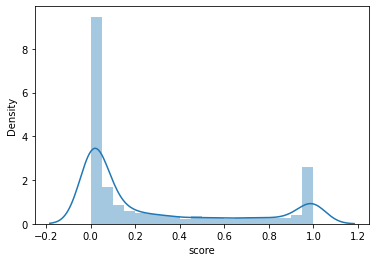

In [22]:
potencial_digital = (dfpandas.groupby(["customer_id", "group_transaction_type"])
["digital_operations_number", "non_digital_operations_number"].sum())
potencial_digital["total"] = potencial_digital.sum(axis = 1)
potencial_digital["digital_perc"] = potencial_digital.digital_operations_number / \
potencial_digital["total"]
potencial_digital["nondigital_perc"] = potencial_digital.non_digital_operations_number / \
potencial_digital["total"]
potencial_digital.reset_index(inplace = True)
potencial_digital = potencial_digital[(potencial_digital.group_transaction_type != "VOSTRO") &
                                     (potencial_digital.group_transaction_type != "COMPRA VENTA DIVISAS") ]
total_cliente = potencial_digital.groupby("customer_id")["total"].sum()
potencial_digital.set_index("customer_id", inplace = True)
potencial_digital["total_cliente"] = total_cliente
new_frame = potencial_digital.merge(producto_digital[ ["digital_perc", "total"] ], how = "left", left_on = "group_transaction_type", right_index = True)
new_frame["porcentaje_transacciones"] = new_frame.total_x / new_frame.total_cliente
new_frame["pondered_perc"] = (1 - new_frame.digital_perc_x).pow(new_frame.digital_perc_y)
new_frame["score"] = new_frame.pondered_perc * new_frame.porcentaje_transacciones
score_cliente = new_frame.groupby("customer_id")["score"].sum()
sns.distplot(score_cliente[score_cliente > 0])

## Calcular cost to serve



In [25]:
costos = pd.read_csv("tabla_costos.csv")

In [26]:
dfpandas = dfpandas.reset_index().merge(costos, how = "left", on = "group_transaction_type") 


In [27]:
dfpandas["cost_transaction_no_digital"] = dfpandas.costo * dfpandas.non_digital_operations_number
dfpandas["cost_transaction_digital"] = .2 * dfpandas.digital_operations_number

In [28]:
dfpandas["cost_serve"] = dfpandas.cost_transaction_digital + dfpandas.cost_transaction_no_digital

In [29]:
cost_cliente = dfpandas.groupby("customer_id")["cost_serve", "cost_transaction_no_digital", 
                                               "cost_transaction_digital"].agg(["mean", "sum"])
cost_cliente.columns = ["mean_cost", "sum_cost", "cost_mean_ana", "cost_sum_ana", "cost_mean_dig", "cost_sum_dig"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


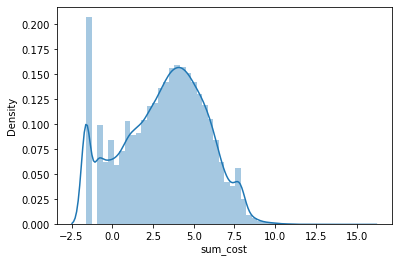

In [30]:
sns.distplot(np.log(cost_cliente.sum_cost))

## Crear tabla a nivel cliente


### Tabla a nivel cliente de operaciones


In [ ]:
dfpandas.columns

Index(['customer_id', 'group_transaction_type', 'digital_total_amount',
       'non_digital_total_amount', 'total_transaction_amount',
       'digital_operations_number', 'non_digital_operations_number',
       'total_operations_number', 'digital_transactions_per',
       'non_digital_transactions_per', 'cutoff_date', 'group_tx',
       'suma_tx_fin', 'numero_tx_fin', 'costo', 'cost_transaction_no_digital',
       'cost_transaction_digital', 'cost_serve', 'quarter'],
      dtype='object')

In [31]:
tabla_analisis = (dfpandas.
                 groupby("customer_id")[["suma_tx_fin", "numero_tx_fin"]].min())

In [33]:
tabla_analisis["cost_avg"] = cost_cliente.mean_cost
tabla_analisis["cost_sum"] = cost_cliente.sum_cost
tabla_analisis["cost_sum_dig"] = cost_cliente.cost_sum_dig 
tabla_analisis["cost_sum_ana"] = cost_cliente.cost_sum_ana
tabla_analisis["cost_sum_log"] = np.log(tabla_analisis.cost_sum)

tabla_analisis["log_suma_tx_fin"] = np.log(tabla_analisis.suma_tx_fin)
tabla_analisis["log_numero_tx_fin"] = np.log(tabla_analisis.numero_tx_fin)

In [34]:
tabla_analisis["numero_tx_fin_dig"] = dfpandas.groupby('customer_id')['digital_operations_number'].sum()
tabla_analisis["suma_tx_fin_dig"] = dfpandas.groupby('customer_id')['digital_total_amount'].sum()
tabla_analisis["numero_tx_fin_ana"] = dfpandas.groupby('customer_id')['non_digital_operations_number'].sum()
tabla_analisis["suma_tx_fin_ana"] = dfpandas.groupby('customer_id')['non_digital_total_amount'].sum()

In [36]:
tabla_analisis["potencial_digital"] = score_cliente

In [37]:
tabla_analisis["tipo_cliente"] = "Mixto"
tabla_analisis.loc[tabla_analisis.potencial_digital == 1, "tipo_cliente"] = "No digital"
tabla_analisis.loc[tabla_analisis.potencial_digital == 0, "tipo_cliente"] = "Digital"

### Unir perfil transaccional de clientes




In [41]:
tabla_analisis.reset_index(inplace = True)

In [42]:
tabla_analisis.set_index("customer_id", inplace = True)
tabla_analisis = tabla_analisis.merge(clientes_perfil_tx, how = "left", left_index = True, right_index = True)
tabla_analisis = tabla_analisis.merge(clientes_perfil_sum, how = "left", left_index = True, right_index = True)

In [43]:
tabla_analisis.head()

,suma_tx_fin,numero_tx_fin,cost_avg,cost_sum,cost_sum_dig,cost_sum_ana,cost_sum_log,log_suma_tx_fin,log_numero_tx_fin,numero_tx_fin_dig,...,TX INVERSIONES,TX ODP INTERNACIONAL,TX OTROS,TX PAGOS A TERCEROS,SUM ENTRE CUENTAS,SUM INTERBANCARIOS,SUM INVERSIONES,SUM ODP INTERNACIONAL,SUM OTROS,SUM PAGOS A TERCEROS
customer_id,,,,,,,,,,,,,,,,,,,,,
00068373,2.352489e+07,98,0.700000,19.6,19.6,0.0,2.975530,16.973570,4.584967,98,...,0.00,0.000000,0.0,0.571429,0.082814,0.226599,0.00000,0.000000,0.0,0.690586
00105376,2.266545e+05,17,0.850000,3.4,3.4,0.0,1.223775,12.331182,2.833213,17,...,0.00,0.117647,0.0,0.294118,0.084736,0.382756,0.00000,0.032752,0.0,0.499756
00171484,1.933578e+08,305,2.346154,61.0,61.0,0.0,4.110874,19.080053,5.720312,305,...,0.00,0.000000,0.0,0.521311,0.003774,0.601006,0.00000,0.000000,0.0,0.395220
00173193,2.338680e+06,11,2.200000,2.2,2.2,0.0,0.788457,14.665097,2.397895,11,...,0.00,0.000000,0.0,1.000000,0.000000,0.000000,0.00000,0.000000,0.0,1.000000
00209430,3.280358e+06,25,1.250000,5.0,5.0,0.0,1.609438,15.003463,3.218876,25,...,0.36,0.000000,0.0,0.240000,0.000000,0.202699,0.62404,0.000000,0.0,0.173261


## Analisis de cluster



In [46]:
tabla_analisis_f = tabla_analisis[(tabla_analisis['numero_tx_fin'] > 6) & 
                                  (tabla_analisis['suma_tx_fin'] > 50000)]

### Filtrar variables y transacciones


In [44]:
col_cluster = [ 'cost_sum_log',  'potencial_digital', "TX INVERSIONES"]

In [48]:
X = tabla_analisis_f.loc[  (tabla_analisis_f['potencial_digital'] > 0) 
                                  & (tabla_analisis_f['potencial_digital'] <= 1) & (tabla_analisis_f.cost_sum < 70000)
    , col_cluster].dropna()

In [ ]:
len(X)

### Normalizar la tabla


In [49]:
from sklearn import preprocessing
mn_scaler = preprocessing.MinMaxScaler()
X_mn = pd.DataFrame(mn_scaler.fit_transform(X[col_cluster]))
X_mn.columns = col_cluster

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

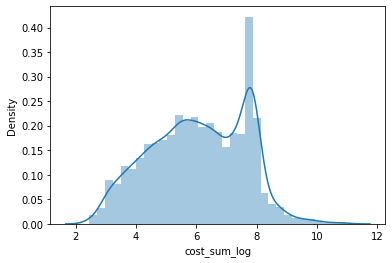

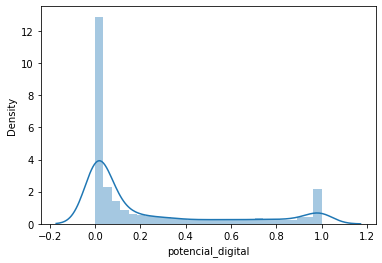

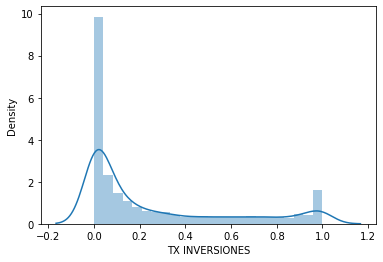

In [50]:
for i in col_cluster:
    plt.figure()
    sns.distplot(X[i], label = i)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

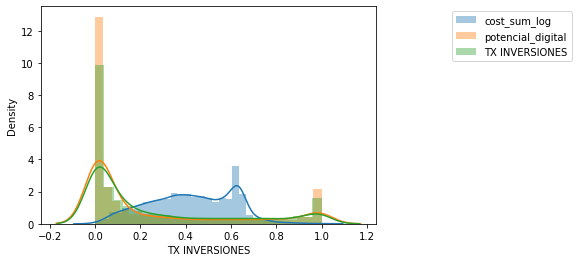

In [51]:
for i in col_cluster:
    sns.distplot(X_mn[i], label = i)
plt.legend(bbox_to_anchor = (1.6, 1))

### Grafica de codo para numero de clusters


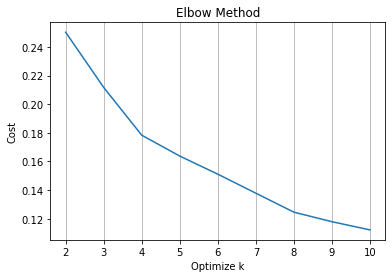

[0.2502117343522217,
 0.21163359115096228,
 0.17831285176439016,
 0.16373160597095632,
 0.15108009286279345,
 0.13779255282305278,
 0.1245503057974732,
 0.11790168922153936,
 0.11216991919234726]

In [52]:
#Asignacion del numero de clusters
#Aplicamos el "Elbow Method" que nos dará una aproximación del número de clústers 
import numpy as np
import pandas as pd 
import math
from scipy.spatial.distance import cdist
cost = []
random_state = 1200
for i in range(2, 11):
    kmeans = KMeans(n_clusters= i, 
                    random_state=random_state).fit(X_mn)    
    cost.append( sum(np.min(cdist(X_mn, 
            kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_mn.shape[0])                   
    random_state += 1 
    
plt.plot(range(2, 11), cost)
plt.title('Elbow Method')
plt.xlabel('Optimize k')
plt.ylabel('Cost')
plt.xticks(np.arange(2, 11, 1.0))
plt.grid(which='major', axis='x')
plt.show()
cost

### Entrenar modelo


In [63]:
# Entrenamiento del modelo.
k = 8
random_state = 1210
kmeans =  kmeans = KMeans(n_clusters= k, 
                    random_state=random_state).fit(X_mn)  
# Predicciones
predictions = kmeans.predict(X_mn)
predictions


array([0, 0, 7, ..., 5, 1, 7], dtype=int32)

Cluster Centers: 
[0.39977062 0.02174506 0.0383537 ]
[0.52127078 0.62917745 0.64074322]
[0.1824568  0.09662464 0.60364862]
[0.55558924 0.32002135 0.306101  ]
[0.18898914 0.04256631 0.07940465]
[0.53946543 0.94049596 0.93421333]
[0.51135127 0.92243458 0.00769116]
[0.62060071 0.05627172 0.05215089]


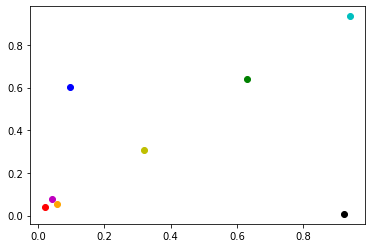

In [64]:

# Observar y manipular los centroides.
centers = kmeans.cluster_centers_
print("Cluster Centers: ")
for center in centers:
    print(center)
centroids = {
    i+1: [centers[i][1], centers[i][2]]
    for i in range(k)
}
centroids
colmap = {1: 'r', 2: 'g', 3: 'b',4:'y',5:'m',6:'c',7:'k', 8: "orange"}
#colmap = {1: 'r', 2: 'g', 3: 'b'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])


### Predecir modelo


In [65]:
X_mn_all = pd.DataFrame(mn_scaler.fit_transform(tabla_analisis_f[col_cluster]))
X_mn_all.columns = col_cluster

In [66]:
predictions = kmeans.predict(X_mn_all)
predictions

array([4, 4, 4, ..., 4, 4, 4], dtype=int32)

In [67]:
tabla_analisis_f["cluster_8_inv"] = predictions

# X["cluster_8_inv"] = predictions
# tabla_analisis_f["cluster_8_inv"] = X.cluster_8_inv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Observar modelo y generar categorías

In [68]:
fig = px.scatter_3d(tabla_analisis_f[~tabla_analisis_f.cluster_8_inv.isnull()], x= "cost_sum_log", z= 'potencial_digital', y="TX INVERSIONES",
              color='cluster_8_inv')
fig.show()

In [69]:
tabla_analisis_f.groupby("cluster_8_inv")[['cost_sum_log',  'potencial_digital', "TX INVERSIONES", 'TX ENTRE CUENTAS', 'TX INTERBANCARIOS', 'TX ODP INTERNACIONAL', 'TX OTROS',
       'TX PAGOS A TERCEROS' ]].mean().sort_values(by = "TX INVERSIONES")

,cost_sum_log,potencial_digital,TX INVERSIONES,TX ENTRE CUENTAS,TX INTERBANCARIOS,TX ODP INTERNACIONAL,TX OTROS,TX PAGOS A TERCEROS
cluster_8_inv,,,,,,,,
6,6.863840,0.922175,0.007645,0.244936,0.509632,0.219353,0.000000,0.018435
4,2.751869,0.002175,0.010976,0.135865,0.500620,0.012110,0.000016,0.340413
0,5.732154,0.005132,0.011961,0.087109,0.500256,0.009021,0.000016,0.391636
7,8.573713,0.052303,0.046100,0.097900,0.407343,0.010532,0.000001,0.438123
3,7.183210,0.316157,0.299225,0.117766,0.332080,0.018363,0.000003,0.232564
2,3.161973,0.032615,0.599415,0.082237,0.181165,0.003519,0.000000,0.133665
1,6.910353,0.628511,0.638138,0.094082,0.152315,0.007291,0.000004,0.108170
5,7.046347,0.940960,0.935140,0.016205,0.027747,0.002556,0.000000,0.018352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



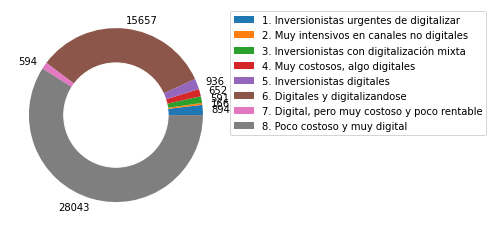

In [70]:
tabla_analisis_f["cluster_8_label"] = tabla_analisis_f.cluster_8_inv.map({5.0: "1. Inversionistas urgentes de digitalizar",
                                    6.0: "2. Muy intensivos en canales no digitales",
                                    1.0: "3. Inversionistas con digitalización mixta",
                                    3.0: "4. Muy costosos, algo digitales ",
                                    2.0: "5. Inversionistas digitales",
                                    0.0: "6. Digitales y digitalizandose",
                                    7.0: "7. Digital, pero muy costoso y poco rentable",
                                    4.0: "8. Poco costoso y muy digital"})

# Create a pieplot


patches, texts = plt.pie(tabla_analisis_f["cluster_8_label"].value_counts().sort_index().to_frame(),
                         labels = tabla_analisis_f["cluster_8_label"].value_counts().sort_index().to_frame()["cluster_8_label"])
plt.legend(patches, tabla_analisis_f["cluster_8_label"].value_counts().sort_index().index, loc="best",
           bbox_to_anchor = (1,1))
#plt.show()
 
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
 
plt.show()


In [ ]:
# tabla_analisis_f.to_csv('Output/clusters/cluster_v4.0_3var_8clusters.csv')
# clust = pd.read_csv('Output/clusters/cluster_v4.0_3var_8clusters.csv', dtype={'customer_id': object})

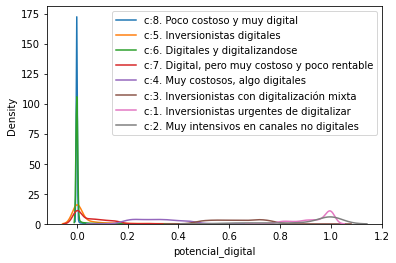

In [71]:
for i in tabla_analisis_f.cluster_8_label.unique():
    sns.kdeplot(tabla_analisis_f.loc[tabla_analisis_f.cluster_8_label == i, "potencial_digital"], label = "c:" + str(i))
    plt.legend()

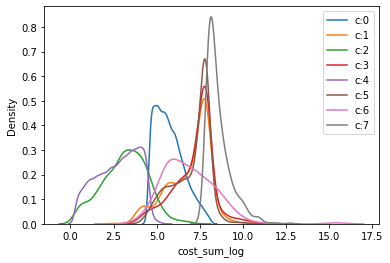

In [72]:
for i in range(0,8):
    sns.kdeplot(tabla_analisis_f.loc[tabla_analisis_f.cluster_8_inv == i,  'cost_sum_log'], label = "c:" + str(i))
    plt.legend()

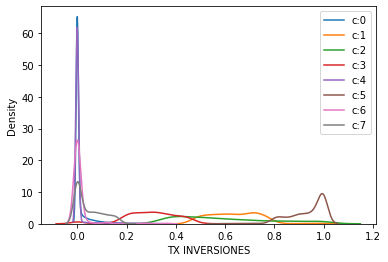

In [74]:
for i in range(0,8):
    sns.kdeplot(tabla_analisis_f.loc[tabla_analisis_f.cluster_8_inv == i, 'TX INVERSIONES'], label = "c:" + str(i))
    plt.legend()